# MadMiner tutorial for Parton-Level Analysis

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

Before you execute this notebook, make sure you have running installations of MadGraph. In addition, MadMiner and LHEMiner have to be in your PYTHONPATH.

In [ ]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.sampling import combine_and_shuffle
from madminer.lhe import LHEProcessor

Please enter here the path to your MG5 root directory.

In [ ]:
mg_dir = '/Users/felixkling/work/MG5_aMC_v2_6_2'

## 1. Define parameter space

After creating a `GoldMine` instance, the first important step is the definition of the parameter space. Each model parameter is characterized by a name as well as the LHA block and ID.

If morphing is used, one also has to specify the maximal power with which the parameter contributes to the squared matrix element. For instance, a parameter that contributes only to one vertex, will typically have `morphing_max_power=2`, while a parameter that contributes to two vertices usually has `morphing_max_power=4`. Exceptions arise for instance when the interference effects between the SM and dimension-six operators are modelled, but the square of the dimension-six amplitude (subleading in 1/Lambda) is not taken into account, in which case `morphing_max_power=1`. Finally, the `parameter_range` argument defines the range of parameter values that are used for the automatic optimization of the morphing basis.

In [ ]:
miner = MadMiner()

miner.add_parameter(
    lha_block='dim6',
    lha_id=2,
    parameter_name='CWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)
miner.add_parameter(
    lha_block='dim6',
    lha_id=5,
    parameter_name='CPWL2',
    morphing_max_power=2,
    parameter_range=(-50.,50.)
)

## 2. Define benchmark points (evaluation points for |M|^2)

The next step is the definition of all the points at which the weights (squared matrix elements) should be evaluated by MadGraph. We call these points "benchmarks".

### 2a. Set benchmarks by hand

One can define benchmarks by hand:

In [ ]:
miner.add_benchmark(
    {'CWL2':0., 'CPWL2':0.},
    'sm'
)
miner.add_benchmark(
    {'CWL2':20., 'CPWL2':0.},
    'w'
)
miner.add_benchmark(
    {'CWL2':50., 'CPWL2':0.},
    'w2'
)

### 2b. Benchmarks for morphing

If morphing is used, the function `set_benchmarks_from_morphing` has to be called. With the option `keep_existing_benchmarks=True`, MadMiner will keep all the benchmark points defined beforehand and run a simple optimization algorithm to fix the remaining ones for the basis (which may be none). Otherwise, MadMiner will optimize the full basis and forget about all previously defined benchmark points. The argument `n_trials` determines the number of random candidate bases that the optimization algorithm goes through.

In [ ]:
miner.set_benchmarks_from_morphing(
    keep_existing_benchmarks=True,
    n_trials=1000,
    max_overall_power=2
)

Let's have a look at the resulting morphing basis and the "morphing error", i.e. the sum of squared morphing weights as a function of the parameter space:

In [ ]:
fig = plot_2d_morphing_basis(
    miner.morpher,
    xlabel=r'$c_{W} / \Lambda^2$ [TeV$^{-2}$]',
    ylabel=r'$c_{\tilde{W}} / \Lambda^2$ [TeV$^{-2}$]',
    xrange=(-60.,60),
    yrange=(-60.,60.)
)

## 4. Change UFO Model to include detector smearing

To simulate the resolution of the invariant masses due to detector smearing, we use a simple trick: we change the Higgs propagator to reproduce the wanted (smeared) invariant mass distribution. The following example illustrates how to change the UFO model `EWdim6` to reproduce the invariant mass distribution for $H\to\gamma\gamma$. 

1. We base our simulation of detector effects on the CMS simulation in Fig. 6 (right) of [CMS-PAS-HIG-15-005](https://cds.cern.ch/record/2140979). In particular, we describe the peak region of the $H\to\gamma\gamma$ diphoton mass distribution by a Gaussian 

    \begin{equation}
    Gaus\left(m~|~N,m_H,\sigma\right)=\frac{N}{\sqrt{2\pi}\sigma}\text{Exp}\left[-\frac{1}{2} \left(\frac{m-m_H}{\sigma}\right)^2\right].
    \end{equation}
    
    From a fit to the normalized distribution we obtain: $N=0.92$, $m_H=124.7$ and $\sigma=1.67$. The normalization factor $N$ accounts for the fact, that a gaussian does not describe the tails of the dsitribition well. However, these tails will hardly contribute to the information and we account for the loss of signal rate in these tails through the normalization factor $N$. 


2. We now replace the usual Breit-Wigner propagator with the (square-root) of the Gaussian distribution: 
    
    \begin{equation} 
    \frac{1}{p^2-m_H^2+i \Gamma m_H} \rightarrow \big[\frac{N}{N_{BW}}\frac{1}{\sqrt{2\pi}\sigma}\big]^{1/2} \text{Exp}\left[-\frac{1}{4} \left(\frac{m-m_H}{\sigma}\right)^2\right].
    \end{equation} 
    
    The normalization of the Breit-Wigner is given by  $N_{BW}\approx 2 m_H^2 \Gamma_H / \pi $.  (Here I used $\Gamma_H \ll m_H$. For full formula see [Wikipedia](https://en.wikipedia.org/wiki/Relativistic_Breit%E2%80%93Wigner_distribution)). 
    
    This can simply be implemented in the file `propagators.py` of the UFO model. First define the new propagator. Here I use the values obtained from the fit above and choose the prefactor $(\sqrt{2\pi}\sigma N_{BW} / N)^{1/2} = 12.438$ 
    
    `denominator_Higgs="12.438*cmath.exp(0.25*(cmath.sqrt(P('mu',id)*P('mu',id))-124.7)**2/1.5245**2)" `
    
    Assign the new propagator to to the scalar particles  
    
    `S = Propagator(name = "S",numerator = "complex(0,1)",denominator = denominator_Higgs)`


3. By defaukt, MadGraph doesn't use the content of `propagators.py`. So we have to make sure it's used. This can simply be done by changing the particle information in the `particles.py` file of the UFO model

    `H = Particle(pdg_code = 25, name = 'H', ... , propagator = Prop.S)`
    
    
4. Finally, we will change the `bwcutoff` in `run_card.dat` to ensure that MadGraph integrated over the desired range. The choice of `bwcutoff` depends on the choosen value of the Higgs width in the `param_card.dat`. For $\Gamma_H=4.07$ MeV I would suggest to choose `bwcutoff=2000`, which then covers an integration range of $m_H \pm 2000\times \Gamma_H = 116.9\dots 133.1$ GeV. 

    Note: if you get an error message such as `IEEE_UNDERFLOW_FLAG` or `IEEE_DENORMAL`, it probably means you have choosen a too large value for `bwcutoff`

## 4. Save settings and run MadGraph

The parameter space, benchmark points, and morphing setup are saved in a HDF5 file:

In [ ]:
miner.save('data/madminer_example.h5')

In a next step, MadMiner starts MadGraph and Pythia to generate events and calculate the weights. You have to provide paths to the process card, run card, param card (the entries corresponding to the parameters of interest will be automatically adapted), and an empty reweight card.

The `sample_benchmark` option can be used to specify which benchmark should be used for sampling. If it is not used, MadMiner will automatically use the benchmark that was added first. Finally, if MadGraph is supposed to run in a different Python environment or requires other setup steps, you can use the `initial_command` argument.

Comment: make sure the `event_norm = sum` in the run_card. Otherwise the normalization is wrong by a factor `nevent`.

In [ ]:
miner.run(
    mg_directory=mg_dir,
    proc_card_file='cards/proc_card_parton.dat',
    param_card_template_file='cards/param_card_template.dat',
    reweight_card_template_file='cards/reweight_card_template.dat',
    run_card_file='cards/run_card_parton.dat',
    sample_benchmark='sm',
    initial_command='source ~/.bashrc'
)

## 5. Extract Parton Level Observables / Weights 

Here we extract the parton level information (observables and weights) from the .lhe file. This is done with the LHEProcessor package. 

In [ ]:
lhep = LHEProcessor()

After creating the object, one can add a number of LHE event samples.

In [ ]:
lhep.add_lhe_sample('MG_process/Events/run_01/unweighted_events.lhe.gz',sampling_benchmark="sm")

We also want to specify the Benchmark names, because sometimes the order is mixed up in the LHE files. But fortunately, we already stored them in the HDF5 file. 

In [ ]:
lhep.read_benchmark_names('data/madminer_example.h5')

Not let's define some observables. The `p[i]` correspond to the i'th parton momentum as specified when generating the process.  All of these objects are scikit-hep [LorentzVectors](http://scikit-hep.org/api/math.html#vector-classes), see the link for a documentation of their properties.

In [ ]:
lhep.add_observable('pt_j1', 'p[0].pt')
lhep.add_observable('pt_j2', 'p[1].pt')
lhep.add_observable('m_jj', '(p[0] + p[1]).m')
lhep.add_observable('m_aa', '(p[2] + p[3]).m')

The function `analyse_lhe_samples` extracts all these observables and weights from the LHE file(s) 

In [ ]:
lhep.analyse_lhe_samples()

The values of the observables and the weights are then saved in the HDF5 file. It is possible to overwrite the same file, or to leave the original file intact and save all the data into a new file as follows:

In [ ]:
lhep.save('data/madminer_example_with_lhedata.h5', 'data/madminer_example.h5')

Let's make a quick cross check by plotting a distributions

In [ ]:
fig = plt.figure(figsize=(5,5))

for weights in lhep.weights:
    plt.hist(lhep.observations['m_jj'], range=(0.,1000.), bins=20, histtype='step', weights=weights)

plt.show()

Here I explicitly check the smearing of the mass peak and compare it to the wanted distribution obtained from the experimental collaboration. 

In [ ]:
#Define my fitting function
def myfunction(x, mean, amplitude, standard_deviation):
    return amplitude/np.sqrt(2.0*3.1415*standard_deviation**2) * np.exp( - 0.5*((x - mean) / standard_deviation) ** 2)

#Function to do the plotting
def smearing_validation_plot(filename,lheprocessor,inputrange,label):
    
    #Get Data from Experiment / MadMiner
    exp_data , exp_weights = np.loadtxt(filename)[:,0] , np.loadtxt(filename)[:,1]
    madminer_data , madminer_weights = lheprocessor.observations['m_aa'] , lheprocessor.weights[0]

    #Plot Exp. Data
    fig = plt.figure(figsize=(5,5))
    bin_heights, bin_borders, _ = plt.hist(exp_data, weights=exp_weights,normed=True,
        range=(inputrange[0],inputrange[1]), bins=inputrange[2], 
        histtype='step',color='Red',label=label)

    #Fit to Experiment
    bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
    bestfit, _ = curve_fit(myfunction, bin_centers, bin_heights, p0=[125, 1, 1])
    fitplotrange=np.arange(inputrange[0], inputrange[1], 0.01)
    plt.plot(fitplotrange,myfunction(fitplotrange,bestfit[0],bestfit[1],bestfit[2]),
        color='Black',linestyle='dashed', label='Fit to Experiment')
    
    #Plot MadMiner
    norm = sum(madminer_weights)
    print ('The total cross section is: %.6f pb'%(norm),)
    bin_heights_mm, _ , _ = plt.hist(madminer_data,
        weights = madminer_weights/norm*inputrange[2]/(inputrange[1]-inputrange[0])*bestfit[1],
        range=(inputrange[0],inputrange[1]), bins=inputrange[2], 
         histtype='step',color='Blue',label='MadMiner')  

    #Finish Plot
    plt.legend(loc='upper left')
    upperbound=max(max(bin_heights),max(bin_heights_mm))
    plt.text(inputrange[0],0.75*upperbound,
         r'$\frac{N}{\sqrt{2\pi}\sigma}\exp\left[-\frac{1}{2}\left(\frac{m-m_H}{\sigma}\right)^2\right]$',
         fontsize=14)
    plt.text(inputrange[0],0.65*upperbound,r'$m_H$=%.3f'%(bestfit[0]),fontsize=14)
    plt.text(inputrange[0],0.60*upperbound,r'$N$=%.3f'%(bestfit[1]),fontsize=14)
    plt.text(inputrange[0],0.55*upperbound,r'$\sigma$=%.3f'%(bestfit[2]),fontsize=14)

    plt.show()

#Call Function
smearing_validation_plot('smearing_data/h_2_aa.txt',lhep,[115,130,30],'CMS: PAS HIG-15-005')

## 6. Calculate Fisher Information

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

Here we calculate the Parton Level Fisher Information, using the data extracted from the LHE file. This is done by the MadFisher package. To initialize it, we load the data from an HDF5 file.

In [2]:
from madminer.fisherinformation import FisherInformation
mf = FisherInformation('data/madminer_example_with_lhedata.h5')

15:52  
15:52  ------------------------------------------------------------
15:52  |                                                          |
15:52  |  MadMiner v2018.09.17                                    |
15:52  |                                                          |
15:52  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
15:52  |                                                          |
15:52  ------------------------------------------------------------
15:52  
15:52  Loading data from data/madminer_example_with_lhedata.h5
15:52  Found 2 parameters:
15:52     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
15:52  Found 6 benchmarks:
15:52     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
15:52     w: CWL2 = 20.00, CPWL2 = 0.00e+00
15:52     w2: CWL2 = 50.00, CPWL2 = 0.00e+00
15:52     morphing_basis_vector_3: CWL2 = -3.13e+00, CPWL2 = -4.53e+01
15:52     

The functions `extract_raw_data()` allows to extract the raw data, consisting of the observables and weighst for the morphing benchmarks. Similarly `extract_observables_and_weights(thetas)` allows to extract the observables and weights for a specified list of benchmarks `thetas`. This function is usefull for both cross checks and simple plotting. 

In [3]:
# Get List of Raw Data: Observables and Weights 
x , w = mf.extract_raw_data()

# Get List of Data for specified Benchmark: Observables and Weights 
thistheta=np.array([20,0])
_ , w = mf.extract_observables_and_weights([thistheta])

We can now calculate the Fisher Information for a given benchmark and a given luminosity (in units of pb$^{-1}$) after considering a set of cuts. The cuts can take into account any function of the observables defined when initializing the LHEProcessor. Additionally there are underflow/overflow bins. 

There are multiple Fisher Info options
- `calculate_fisher_information_full_truth(theta,luminosity,cuts)`, which calculates the full Fisher Info, by summing over the Fisher Infos for each event passing the cuts: $I_{ij}^{full} = \sum_{events} I_{ij}(w_i)$
- `calculate_fisher_information_rate(theta,luminosity,cuts)`, which calculates the Fisher Info corresponding to only the rate, by evaluating the Fisher Info of the sum the weights of all events passing the cuts: $I_{ij}^{rate} =  I_{ij}(\sum_{events} w_i)$ 
- `calculate_fisher_information_hist1d(theta,luminosity,cuts,observable,nbins,histrange)`, which calculates the Fisher Info in a 1D histogram, by summing over the Rate Fisher Infos for each bin in the 1D Histogram: $I_{ij}^{hist} =  \sum_{bins} I_{ij}(w_i)$
- `calculate_fisher_information_hist2d(theta,luminosity,cuts,observable1,nbins1,histrange1,observable2,nbins2,histrange2)`, which calculates the Fisher Info in a 2D histogram, by summing over the Rate Fisher Infos for each bin in the 2D Histogram: $I_{ij}^{hist} =  \sum_{bins} I_{ij}(w_i)$

Note that `observable` can be any function of observables

In [57]:
# Define Benchmark
thistheta=np.array([20,0])

#Define luminosity in inverse pb
thislumi=100*1000;

#Define Cuts
thiscuts = ['m_jj>100','pt_j1>100']

#Define Histogram 1D
thisxobservable='m_jj'
thisxrange=(0,5000)
thisxnbins=10

#Define Histogram 2D
thisyobservable='pt_j1'
thisyrange=(0,2000)
thisynbins=10

#Full Fisher Info
fi_full = mf.calculate_fisher_information_full_truth(theta=thistheta,
                                                     luminosity=thislumi,
                                                     cuts=thiscuts
                                                     )
fi_rate = mf.calculate_fisher_information_rate(theta=thistheta,
                                                     luminosity=thislumi,
                                                     cuts=thiscuts
                                                     )
fi_hist1d = mf.calculate_fisher_information_hist1d(theta=thistheta,
                                                       luminosity=thislumi,
                                                       cuts=thiscuts,
                                                       observable=thisxobservable,
                                                       nbins=thisxnbins,
                                                       histrange=thisxrange
                                                       )
fi_hist2d = mf.calculate_fisher_information_hist2d(theta=thistheta,
                                                       luminosity=thislumi,
                                                       cuts=thiscuts,
                                                       observable1=thisxobservable,
                                                       nbins1=thisxnbins,
                                                       histrange1=thisxrange,
                                                       observable2=thisyobservable,
                                                       nbins2=thisynbins,
                                                       histrange2=thisyrange
                                                       )

print ('Full    Fisher Info: \n' , fi_full) 
print ('Rate    Fisher Info: \n' , fi_rate)
print ('Hist 1D Fisher Info: \n' , fi_hist1d) 
print ('Hist 2D Fisher Info: \n' , fi_hist2d) 

Full    Fisher Info: 
 [[ 0.01811331 -0.00546326]
 [-0.00546326  0.02089807]]
Rate    Fisher Info: 
 [[ 0.0083552  -0.00158135]
 [-0.00158135  0.00029929]]
Hist 1D Fisher Info: 
 [[0.012892   0.00021353]
 [0.00021353 0.00714368]]
Hist 2D Fisher Info: 
 [[ 0.01379525 -0.00126411]
 [-0.00126411  0.00956097]]


ToDo List: 
1. Take into account efficiencies (such as for b-tagging)
2. DONE Check luminosity units. 
3. DONE Add Information in 2D Histograms 
4. Add Plot Differential FI
5. Add Plot Reach
6. Add Bar Plot
7. DONE Overflowbin? Underflowbin? 

THE FOLLOWING FUNTIONS ARE WORK IN PROGRESS! DON'T WORK ON THEM!!1!!!11!!!

In [87]:
from madminer.utils.various import create_missing_folders
def plot_det_list_split(matrices,
                        matrices_for_determinants,
                        labels,
                        categories,
                        operatorlabels,
                        filename,
                        additional_label='',
                        top_label='',
                        normalise_determinants=False,
                        use_bar_colors=False,
                        eigenvalue_operator_legend2=True
                       ):
    
    #################################################################################
    # Data
    #################################################################################
    
    epsilon = 1.e-9
    size = len(matrices[1])
    size_lower = len(matrices_for_determinants[1])
    exponent = 1./float(size)
    exponent_lower = 1./float(size_lower)
    
    determinants = [np.linalg.det(m)**exponent_lower for m in matrices_for_determinants]

    # normalise determinants
    if normalise_determinants:
        max_information = max(determinants)
        determinants = determinants / max_information
    else:
        max_information = 1.

    assert len(determinants) == len(labels)
    n_entries = len(determinants)

    print ('')
    for l,d in zip(labels,determinants):
        print (l + ': det I_{ij} =', d)

    eigenvalues = []
    eigenvalues_dominant_components = []
    eigenvalues_composition = []
    
    for m in matrices:
        v,w = np.linalg.eig(m)
        w=np.transpose(w)
        v,w = zip(*sorted(zip(v,w),
                 key=lambda x: x[0],
                 reverse=True))
        temp = []
        temp_dominant_components = []
        temp_composition = []
        for vi,wi in zip(v,w):
            temp.append(vi)
            temp_dominant_components.append(np.argmax(np.absolute(wi)))
            temp_composition.append(wi * wi / (sum(wi * wi)) )

        eigenvalues.append(temp)
        eigenvalues_dominant_components.append(temp_dominant_components)
        eigenvalues_composition.append(temp_composition)
            
    if len(categories) == 0:
        categories = [0 for i in range(n_entries)]
    
    #################################################################################
    # Plotting options
    #################################################################################

    # Base x values
    base_xvalues = np.linspace(0., float(n_entries) - 1., n_entries)
    for i in range(n_entries):
        base_xvalues[i] += (float(categories[i]) * 1.)

    base_xmin = base_xvalues[0]
    base_xmax =  base_xvalues[n_entries-1] + 1.
    
    xpos = base_xvalues + 0.2
    width = 0.6
    xmin_eigenvalues = base_xvalues + 0.08
    xmax_eigenvalues = base_xvalues + 0.92
    xpos_ticks = base_xvalues + 0.5
    
    xpos_lower = base_xvalues + 0.5
    width_lower = 0.8

    if use_bar_colors:
        bar_colors = ['red', 'blue', 'green', 'darkorange', 'fuchsia', 'turquoise']*5
        bar_colors_light = ['red', 'blue', 'green', 'darkorange', 'fuchsia', 'turquoise']*5
    else:
        bar_colors = ['0.5']*30
        bar_colors_light = ['0.9']*30
            
    if size == 2 and r'\widetilde' in additional_label:
        eigenvalue_colors = ['green', 'turquoise']
        operator_order = [0,1]
    elif size == 2:
        eigenvalue_colors = ['blue', 'green']
        operator_order = [0,1]
    elif size == 3:
        eigenvalue_colors = ['blue', 'green', 'red']
        operator_order = [2,0,1]
    elif size == 5:
        eigenvalue_colors = ['darkorange', 'blue', 'fuchsia', 'green', 'red']
        operator_order = [4,1,3,0,2]
    else:
        eigenvalue_colors = ['darkorange', 'blue', 'fuchsia', 'green', 'red', 'turquoise'] * 5.
    eigenvalue_linewidth = 1.5

    #################################################################################
    # Upper plot
    #################################################################################

    # Plot bars!
    fig = plt.figure(figsize=(9.,6.))
    ax1 = plt.subplot(211)
    ax1.set_yscale('log')
    fig.subplots_adjust(left=0.075,right=0.925,bottom=0.15,top=0.95,wspace=0,hspace=0)
        
    # Plot eigenvalues
    for i in range(n_entries):
        ## plt.hlines(eigenvalues[i],
        ##            xmin_eigenvalues[i], xmax_eigenvalues[i],
        ##            [eigenvalue_colors[dc] for dc in eigenvalues_dominant_components[i]],
        ##            linestyles='solid',
        ##            linewidth=eigenvalue_linewidth)

        for eigenvalue, composition in zip(eigenvalues[i],eigenvalues_composition[i]):
            # gap sizing
            n_gaps = -1
            minimal_fraction_for_plot = 0.01
            for fraction in composition:
                if fraction >= minimal_fraction_for_plot:
                    n_gaps += 1
            gap_fraction = 0.04
            gap_correction_factor = 1. - n_gaps * gap_fraction

            fraction_finished = 0.

            for j in range(len(composition)):
                component = operator_order[j]
                fraction = composition[component]
            # for component, fraction in enumerate(composition):
                if fraction >= minimal_fraction_for_plot:
                    plt.hlines([eigenvalue],
                               xmin_eigenvalues[i] + fraction_finished * (xmax_eigenvalues[i] - xmin_eigenvalues[i]),
                               xmin_eigenvalues[i] + (fraction_finished + gap_correction_factor * fraction) * (xmax_eigenvalues[i] - xmin_eigenvalues[i]),
                               eigenvalue_colors[component],
                               linestyles='solid',
                               linewidth=eigenvalue_linewidth)
                    fraction_finished += gap_correction_factor * fraction + gap_fraction

    ax1.set_xlim([base_xmin - 0.2,base_xmax + 0.2])

    if size > 2:
        orderofmagnitudes = 1.e6
        topfactor = 8.
    else:
        orderofmagnitudes = 1.e3
        topfactor = 3.

    ax1.set_ylim([ max([max(ev) for ev in eigenvalues]) / orderofmagnitudes,
                             max([max(ev) for ev in eigenvalues])*topfactor])
    legend_position = max([max(ev) for ev in eigenvalues])*topfactor / (topfactor * orderofmagnitudes)**0.1
    
    ax1.set_xticks(xpos_ticks)
    ax1.set_xticklabels(['' for l in labels], rotation=40, ha='right')
    ax1.set_ylabel(r'$I_{ij}$ eigenvalues')
    ax1.yaxis.set_label_coords(-0.055,0.5)

    plt.title(top_label,
              fontdict={'fontsize':12.},
              loc='right')
    
    # Second axis with typical precision 
    ax2 = ax1.twinx()
    ax2.set_yscale('log')

    def precision_to_information(precision):
        # return 1. / np.maximum(precision,epsilon * np.ones_like(precision)) / np.maximum(precision,epsilon * np.ones_like(precision)) / 0.246**4
        return (np.maximum(precision,epsilon) / 0.246) ** 4.

    def information_to_precision(fisher_inf):
        # return 1. / np.sqrt(np.maximum(fisher_inf,epsilon * np.ones_like(fisher_inf))) / 0.246**2
        return 0.246 * np.maximum(fisher_inf,epsilon) ** 0.25
    
    def tick_function_information(fisher_inf):
        # precision = 1. / np.sqrt(np.maximum(fisher_inf,epsilon * np.ones_like(fisher_inf))) / 0.246**2
        precision = 0.246 * np.maximum(fisher_inf,epsilon) ** 0.25
        return [str(z) for z in precision]
    
    def tick_function_precision(precision):
        return [str(z) for z in precision]

    
    ax2_limits = ax1.get_ylim()
    precision_limits = information_to_precision(ax2_limits)

    ## precision_ticks = np.array([1.e-3,1.e-2,1.e-1,1.,1.e1,1.e2,1.e3])
    precision_ticks = np.array([0.1,0.2,0.5,1.,1.5,2.0,3.0,4.0,5.0])
    ax2_ticks = precision_to_information(precision_ticks)

    #precision_minor_ticks = []
    #for i in [0.01,0.1,1.]:
    #    for j in range(10):
    #        precision_minor_ticks.append(i * j)
    #precision_minor_ticks.append(precision_ticks[-1])
    #precision_minor_ticks = np.array(precision_minor_ticks)
    precision_minor_ticks = np.linspace(0.,5.,51)
    ax2_minor_ticks = precision_to_information(precision_minor_ticks)
    ax2.set_yticks(ax2_ticks,minor=False) 
    ax2.set_yticklabels(tick_function_precision(precision_ticks)) 
    ax2.set_yticks(ax2_minor_ticks,minor=True)  
    ax2.set_ylim(ax2_limits)
  
    # ax2.set_ylabel(r'$\Delta (f / \Lambda^2)_{min}$ [TeV$^{-2}$]')
    ax2.set_ylabel(r'Reach $\Lambda / \sqrt{f}$ [TeV]')
    ax2.yaxis.set_label_coords(1.058,0.5)

    # legend
    if eigenvalue_operator_legend2:

        if size == 2:
            legend_labels = [r'Eigenvector composition:'] + operatorlabels
            legend_labels_x = [0.58,0.88,0.94]
            legend_labels_color = ['black'] + eigenvalue_colors
        else: 
            legend_labels = [r'Eigenvector composition:'] + operatorlabels
            legend_labels_x = [0.94-(len(operatorlabels)-1)*0.1-0.4] + np.linspace(0.94-(len(operatorlabels)-1)*0.1, 0.94, num=2)
            legend_labels_color = ['black'] + eigenvalue_colors
            
        for legend_label,x,col in zip(legend_labels,legend_labels_x,legend_labels_color):
            ax1.text(x * base_xmax,legend_position,
                     legend_label,
                     fontsize=12,
                     color=col,
                     horizontalalignment='left',
                     verticalalignment='center')

    
    
    
    #################################################################################
    # Lower plot
    #################################################################################

    # Plot bars!
    ax3 = plt.subplot(212)

    bar_plot = ax3.bar(xpos_lower,
                      determinants,
                      width=width_lower,
                      log=False)

    for i in range(n_entries):
        bar_plot[i].set_color(bar_colors_light[categories[i]])
        bar_plot[i].set_edgecolor(bar_colors[categories[i]])

    ax3.set_xlim([base_xmin - 0.2,base_xmax + 0.2])
    ax3.set_ylim([0.,max(determinants)*1.05])
    
    ax3.set_xticks(xpos_ticks)
    ax3.set_xticklabels(labels, rotation=40, ha='right')
    if normalise_determinants:
        ax3.set_ylabel(r'$(\det \ I_{ij} / \det \ I_{ij}^{\mathrm{full}})^{1/' + str(size_lower) + r'}$')
    else:
        ax3.set_ylabel(r'$(\det \ I_{ij})^{1/' + str(size_lower) + r'}$')
    ax3.yaxis.set_label_coords(-0.052,0.5)

    if len(additional_label) > 0:
        ax3.text(0.99 * base_xmax,max(determinants) * 0.93,
                 additional_label,
                 fontsize=12,
                 color='black',
                 horizontalalignment='right',
                 verticalalignment='center')

    def precision_to_norm_information(precision):
        # return 1. / np.maximum(precision,epsilon * np.ones_like(precision)) / np.maximum(precision,epsilon * np.ones_like(precision)) / 0.246**4
        return (np.maximum(precision,epsilon) / 0.246) ** 4. / max_information

    def norm_information_to_precision(fisher_inf):
        # return 1. / np.sqrt(np.maximum(fisher_inf,epsilon * np.ones_like(fisher_inf))) / 0.246**2
        return 0.246 * np.maximum(fisher_inf * max_information,epsilon) ** 0.25
    
    def tick_function_precision(precision):
        return [str(z) for z in precision]

    # Second axis with typical precision 
    ax4 = ax3.twinx()
    ax4_limits = ax3.get_ylim()
    precision_limits = norm_information_to_precision(np.array(ax4_limits))

    ## precision_ticks = np.array([1.e-3,1.e-2,1.e-1,1.,1.e1,1.e2,1.e3])
    precision_ticks = np.array([0.5,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
    ax4_ticks = precision_to_norm_information(precision_ticks)

    ## precision_minor_ticks = []
    ## for i in [0.01,0.1,1.]:
    ##     for j in range(10):
    ##         precision_minor_ticks.append(i * j)
    ## precision_minor_ticks.append(precision_ticks[-1])
    ## precision_minor_ticks = np.array(precision_minor_ticks)
    precision_minor_ticks = np.linspace(0.1,5.,50)
    ax4_minor_ticks = precision_to_norm_information(precision_minor_ticks)

    ax4.set_yticks(ax4_ticks,minor=False)
    ax4.set_yticklabels(tick_function_precision(precision_ticks))
    ax4.set_yticks(ax4_minor_ticks,minor=True)
    
    ax4.set_ylim(ax4_limits)

    # ax4.set_ylabel(r'$\Delta (f / \Lambda^2)_{min}$ [TeV$^{-2}$]')
    ax4.set_ylabel(r'Reach $\Lambda / \sqrt{f}$ [TeV]')
    ax4.yaxis.set_label_coords(1.058,0.5)
    

    plt.show()
    #create_missing_folders([os.path.dirname(filename)])    
    #plt.savefig(filename, dpi=300)
    #plt.close()

    
    


/Users/felixkling/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars



full: det I_{ij} = 0.018673138336998966
rate: det I_{ij} = nan
m_jj: det I_{ij} = 0.009594305771625948
m_jj+pt_j1: det I_{ij} = 0.011414814217833842


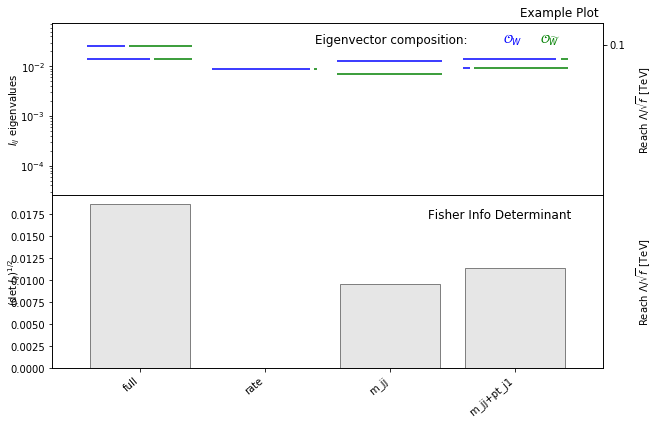

In [90]:
list_of_fisherinfos=[fi_full,fi_rate,fi_hist1d,fi_hist2d]
list_of_labels=["full","rate","m_jj","m_jj+pt_j1"]
list_of_cathegories=[1,1,1,1]
list_of_operators=[r'$\mathcal{O}_{W}$',r'$\mathcal{O}_{\widetilde{W}}$']

plot_det_list_split(matrices=list_of_fisherinfos,
                    matrices_for_determinants=list_of_fisherinfos,
                    labels=list_of_labels,
                    categories=list_of_cathegories,
                    operatorlabels=list_of_operators,
                    filename="figures/output.pdf",
                    additional_label="Fisher Info Determinant",
                    top_label="Example Plot ",
                    normalise_determinants=False,
                    use_bar_colors=False,
                    eigenvalue_operator_legend2=True)

In [81]:
list_of_labels=["full","rate","m_jj","m_jj+pt_j1"]
list_of_labels[2]

u'm_jj'